# Прогнозирование оттока пользователей фитнес-центра

Для исследования предоставлены данные, которые содержат информацию о клиентах фитнес-центра за месяц до оттока и в месяц оттока.

Цель исследования: определить основные признаки, которые характерны для оставшихся и ушедших клиентов, дать рекомендации для их привлечения и удержания.

**Согласно документации:**

Данные клиента за предыдущий до проверки факта оттока месяц:
- gender — пол;
- Near_Location — проживание или работа в районе, где находится фитнес-центр;
- Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- Phone — наличие контактного телефона;
- Age — возраст;
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
- Group_visits — факт посещения групповых занятий;
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
- Churn — факт оттока в текущем месяце.

## План работы

1. [Изучение данных](#1)

2. [Предобработка данных](#2)

3. [Исследовательский анализ данных (EDA)](#3)

4. [Модель прогнозирования оттока клиентов](#4)

5. [Кластеризация клиентов](#5)

6. [Общие выводы](#6)

<a name="1"><h2>1 Изучение данных</h2></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-dark')
%config InlineBackend.figure_format = 'retina'

Прочитаем данные:

In [2]:
df = pd.read_csv('/content/gym_churn.csv')

Посмотрим первые десять записей:

In [3]:
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Посмотрим общую информацию о таблице:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В таблице 13 столбцов и 4000 записей, пропусков нет.

<div style="border: solid green 2px; padding: 20px">

**Выводы**
    
* Так как названия столбцов записаны разным шрифтом, приведем их к одному стилю, перезаписав названия в нижнем регистре.
* Поменяем тип в столбце 'Month_to_end_contract' с float на int, так как количество месяцев это данные целочисленного типа.</div>

<a name="2"><h2>2 Предобработка данных</h2></a>

Переведем названия колонок в нижний регистр:

In [5]:
df.columns = df.columns.str.lower()

Проверим результат:

In [6]:
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Заменим тип в столбце 'month_to_end_contract' на целочисленный:

In [7]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

Проверим таблицу на наличие дубликатов:

In [8]:
df.duplicated().sum()

0

Дубликатов нет.

<div style="border: solid green 2px; padding: 20px">

**Выводы**

* Записали названия столбов в нижнем регистре.
* Заменили тип данных на целочисленный в столбце с количеством месяцев до окончания действующего абонемента.
* Проверили таблицу на наличие дубликатов.</div>

<a name="3"><h2>3 Исследовательский анализ данных (EDA)</h2></a>

Посмотрим на значения признаков методом describe():

In [9]:
df.describe().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Согласно полученным данным:
* Клиентами фитнес-центра являются примерно одинаковое количество мужчин и женщин;
* Большинство живут или работают рядом;
* Почти половина (49%) это сотрудники компаний-партнёров клуба;
* 31% пришли благодаря акции «приведи друга»; 
* 90% оставляют свой контактный телефон;
* 41% клиентов посещают групповые занятия;
* Половина заключает контракт на месяц и совсем редко на год;
* Средний возраст 29 лет, при этом максимальный возраст 41 год;
* Выручка от других услуг фитнес-центра в среднем составляет 146.94;
* Половина клиентов посещают центр 3 месяца и максимум 31 месяц;
* Обычно клиенты посещают клуб два раза в неделю;
* В среднем 27% клиентов уходят в отток.

Построим сводную таблицу со средними значениями признаков по оставшимся и ушедшим клиентам:

In [10]:
features_mean = df.groupby('churn').mean().T.round(2)
features_mean.columns = ['Оставшиеся клиенты','Ушедшие клиенты']
features_mean

,Оставшиеся клиенты,Ушедшие клиенты
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Основные выводы:
* Пол и наличие контактного телефона не влияют на отток, процент по оставшимся и ушедшим одинаковый, в случае с полом это 51%, а телефон оставляли в обоих случаях 90% клиентов;
* Большинство оставшихся живут или работают рядом (87% вместо 77%), заключают конктракт на более длительный период, в среднем на 4 месяца и тратят больше средств на дополнительные услуги, в среднем на 43,37;
* Сотрудники компаний-партнёров, а также клиенты, посещающие групповые занятия или пришедшие по приглашению друга тоже уходят реже. Клиентов по партнёрской программе или посещающих групповые программы из оставшихся больше на 20%, по приглашению друга на 17%.
* Клиенты, уходящие в отток, в большинстве посещают клуб не больше месяца и чаще моложе оставшихся на 3 года. 

Так как в таблице значения разного типа (бинарные, дискретные и непрерывные), то разделим графики в зависимости от вида.
Построим столбчатые гистограммы для признаков 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits' и 'month_to_end_contract':

In [11]:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'month_to_end_contract'] 
for column in columns:
    table = df.groupby(['churn',column])[column].agg(['count']).reset_index()
    fig = px.bar(table, x=column, y="count", color="churn", text="count", title=('Оставшиеся и ушедшие клиенты по признаку '+ str(column)))
    fig.update_layout(width=600, height=400, xaxis_title=column, yaxis_title="Количество клиентов") 
    fig.show()

Построим гистограммы и распределения для признаков 'age', 'avg_additional_charges_total', 'lifetime',
       'avg_class_frequency_total' и 'avg_class_frequency_current_month':

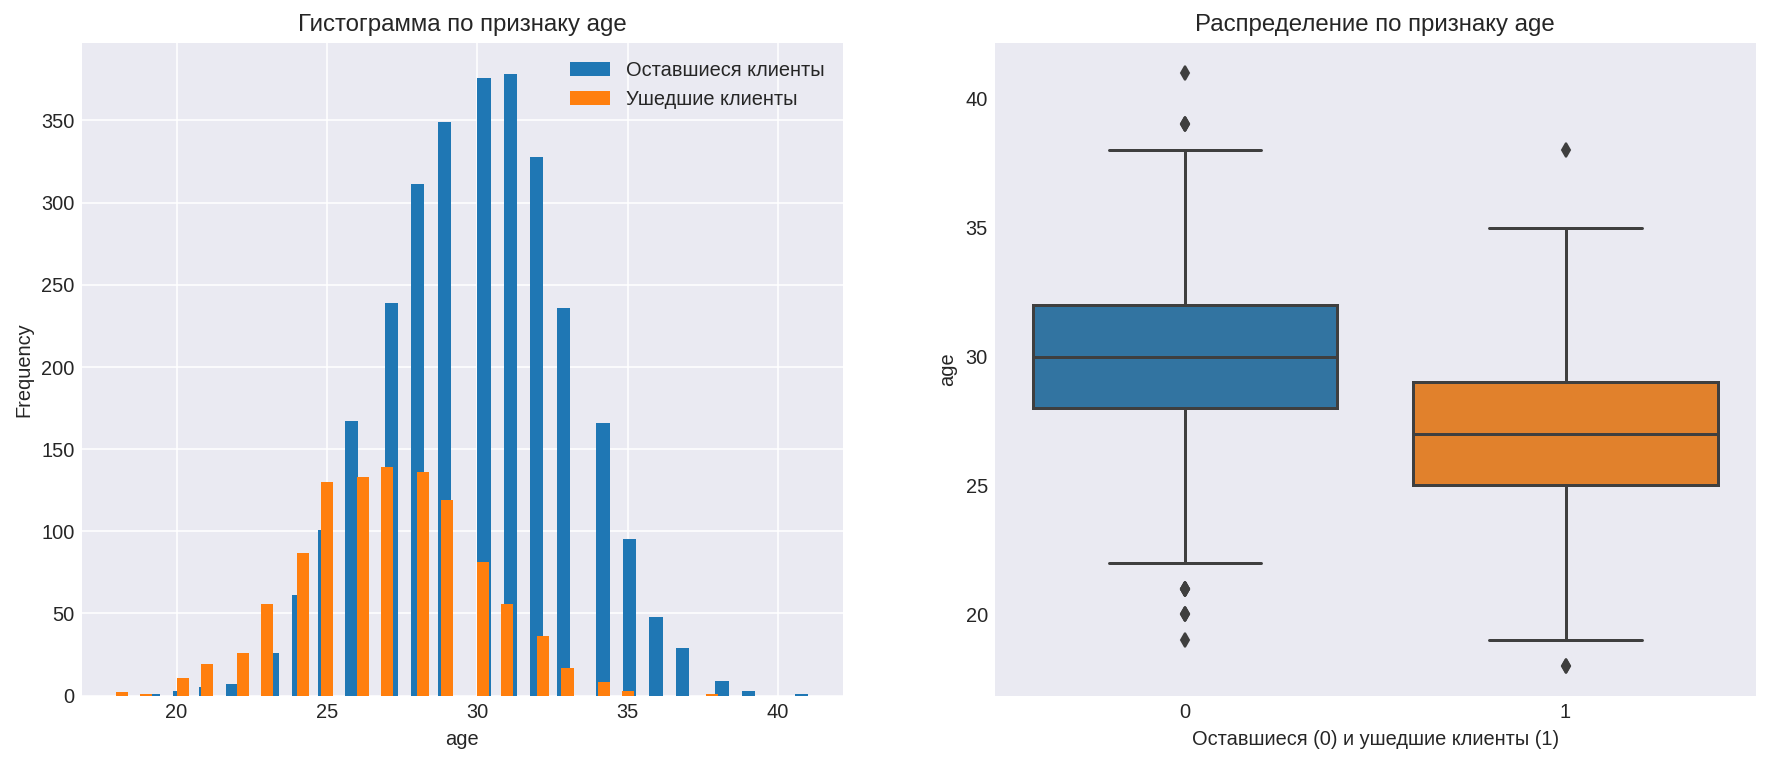

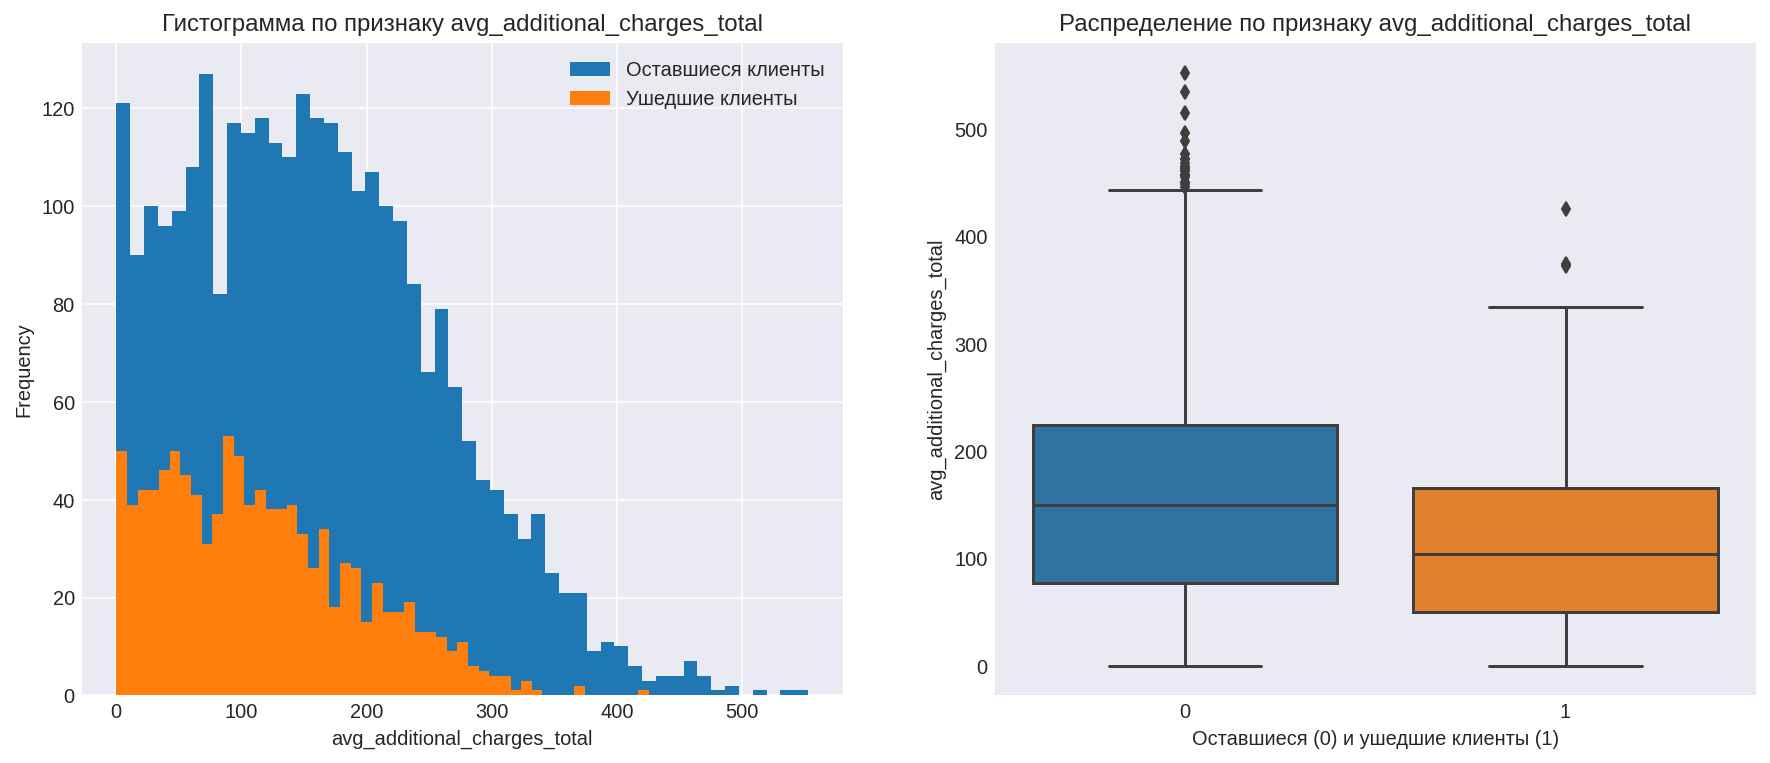

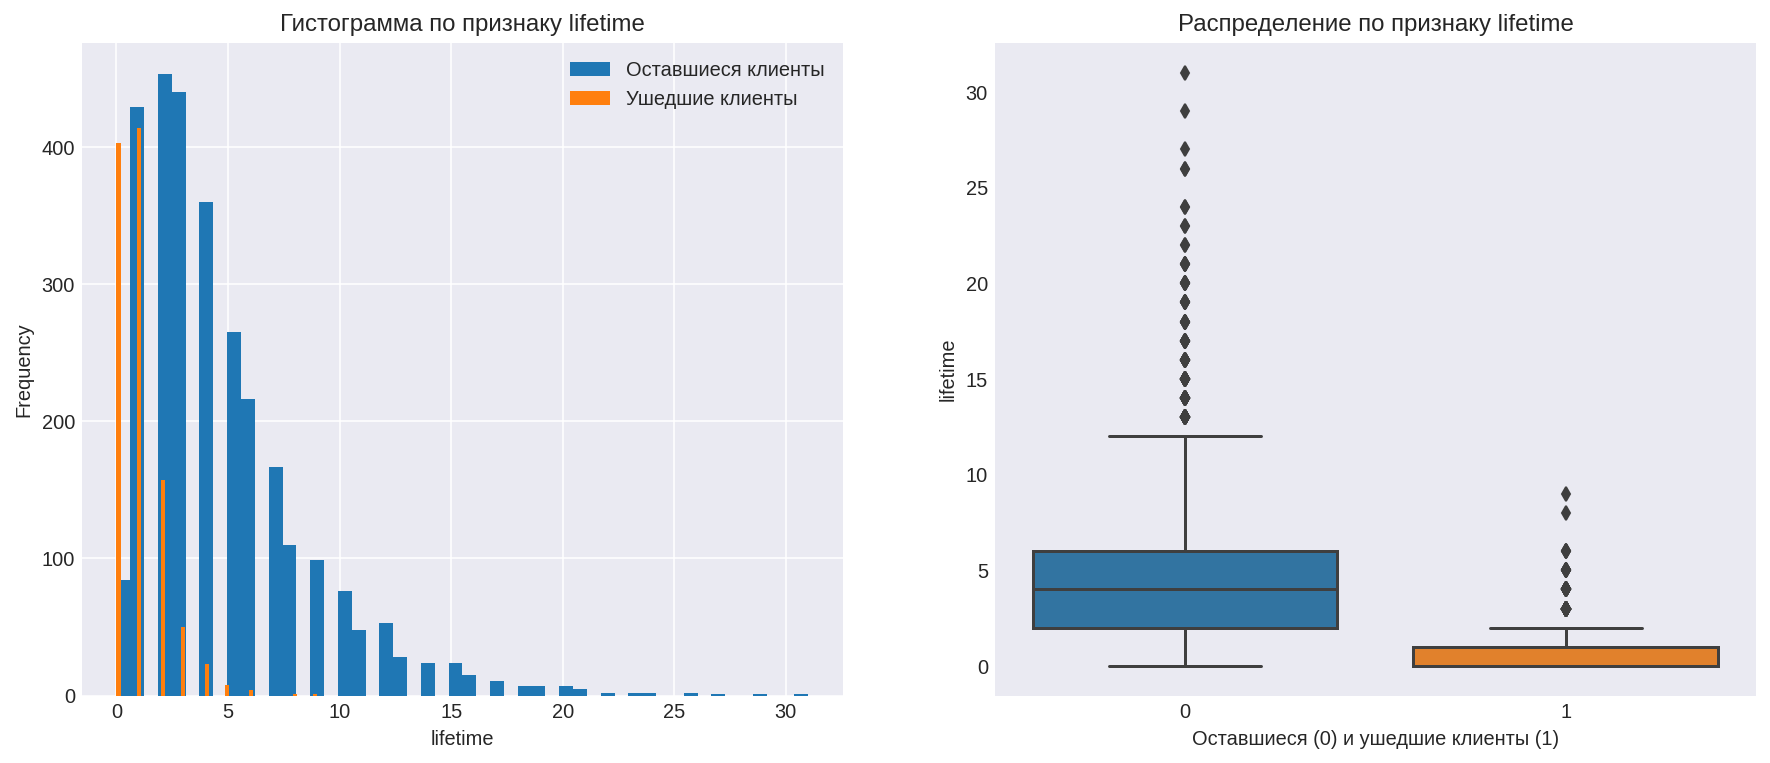

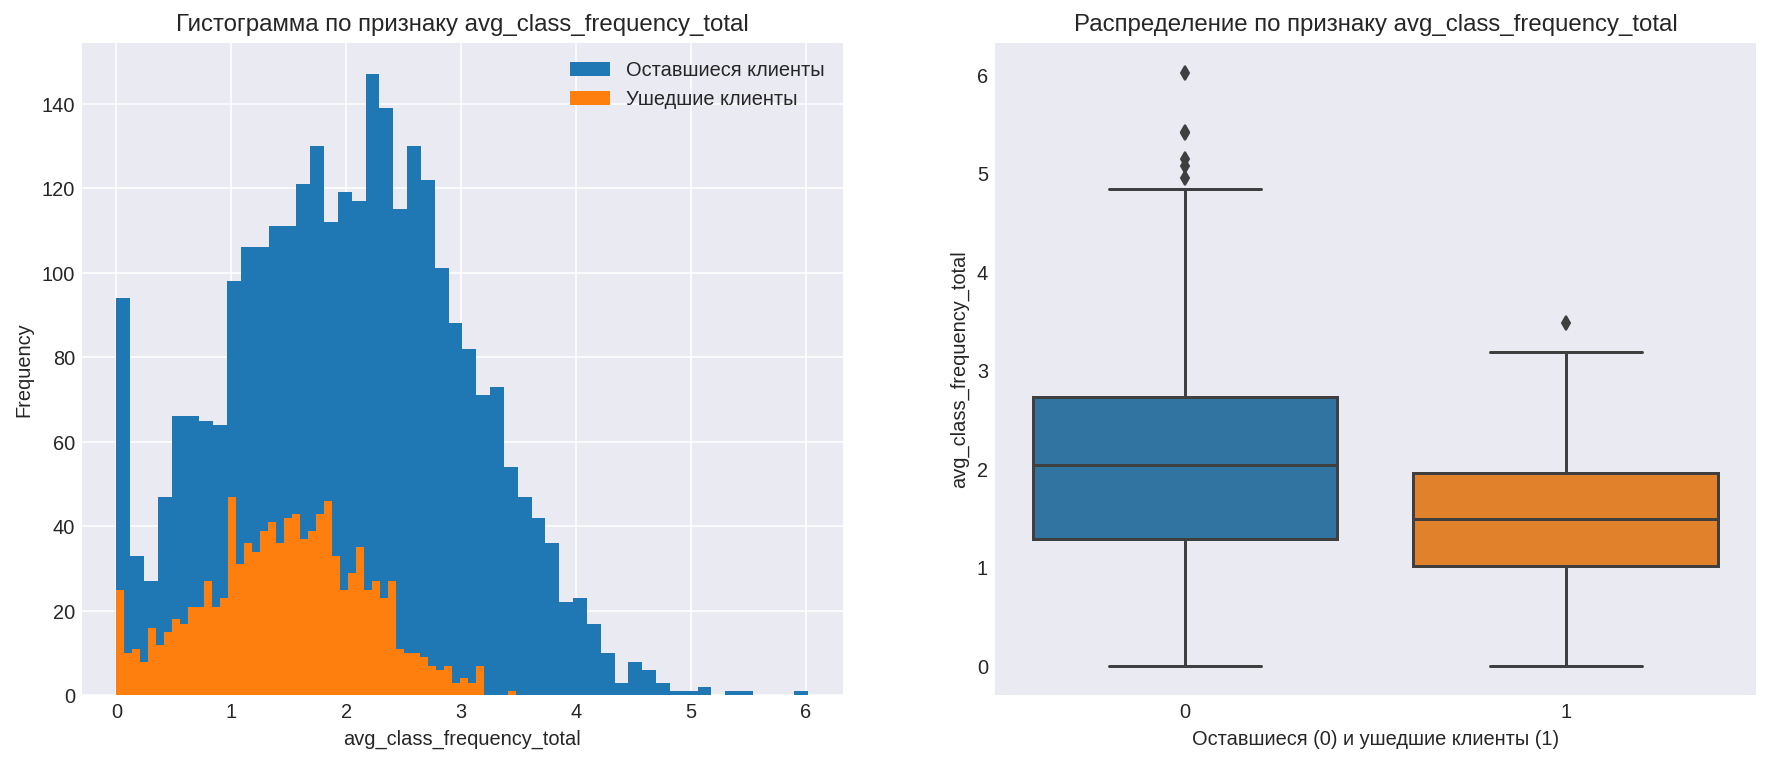

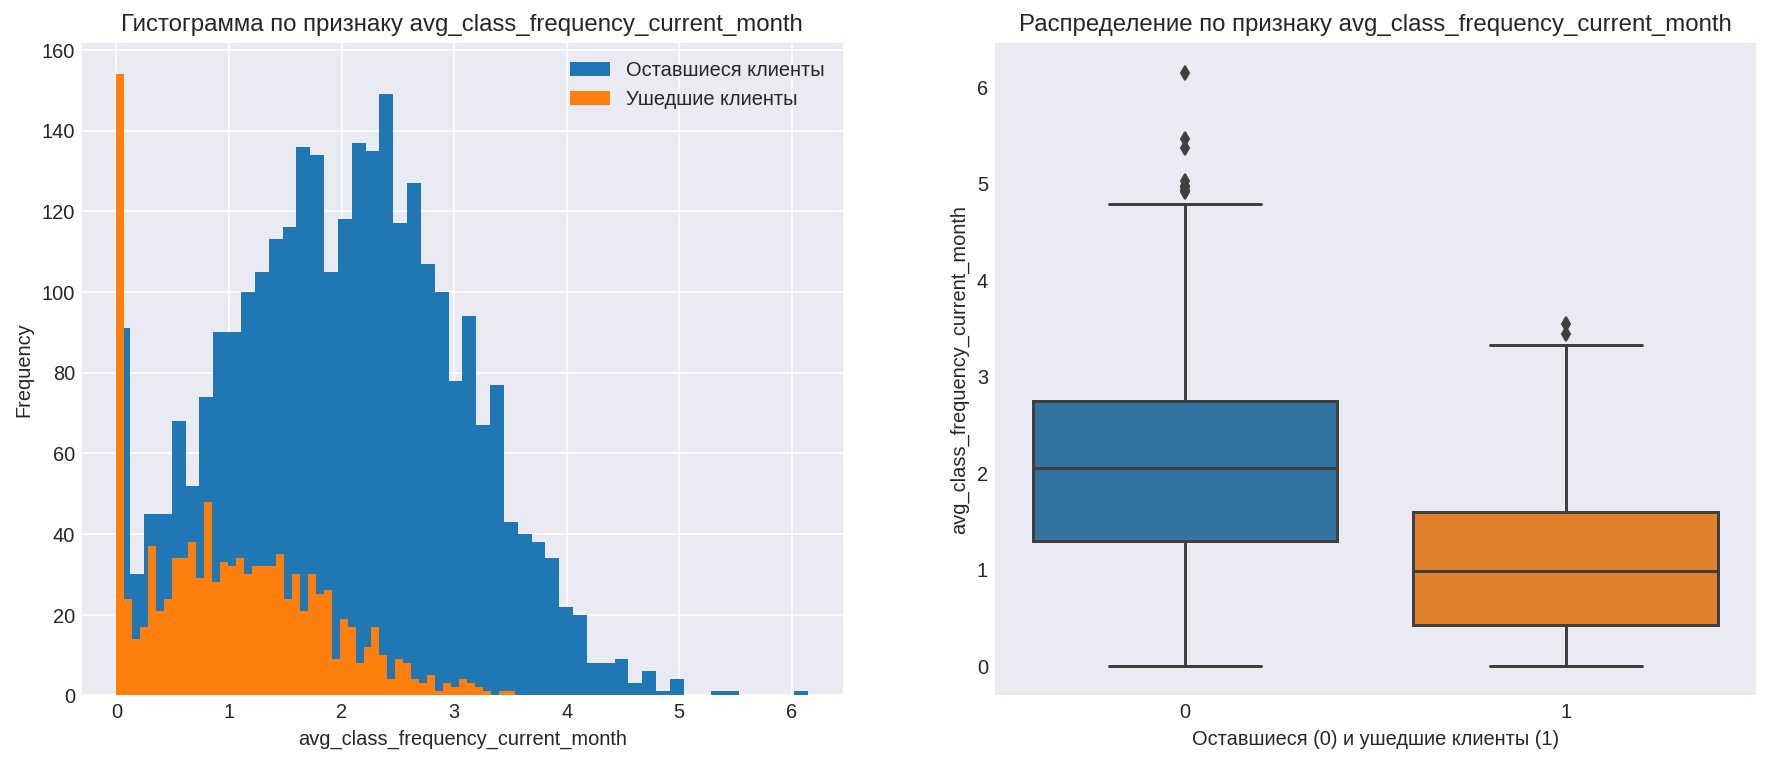

In [12]:
columns = ['age', 'avg_additional_charges_total', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']
for column in columns:
    figure, ax = plt.subplots(1,2,figsize=(15,6))
    df.groupby('churn').plot(kind='hist', y=column, title=column, bins=50, grid=True, ax=ax[0]);
    sns.boxplot(x="churn", y=column, data = df, ax=ax[1])
    ax[0].set_title('Гистограмма по признаку '+ str(column))
    ax[1].set_title('Распределение по признаку '+ str(column))  
    ax[0].set_xlabel(column)
    ax[1].set_xlabel('Оставшиеся (0) и ушедшие клиенты (1)')
    ax[0].legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
    plt.show()

На графиках боллее наглядно отображены сделанные выводы по сводной таблице по оставшимся и ушедшим клиентам.

Построим матрицу корреляции:

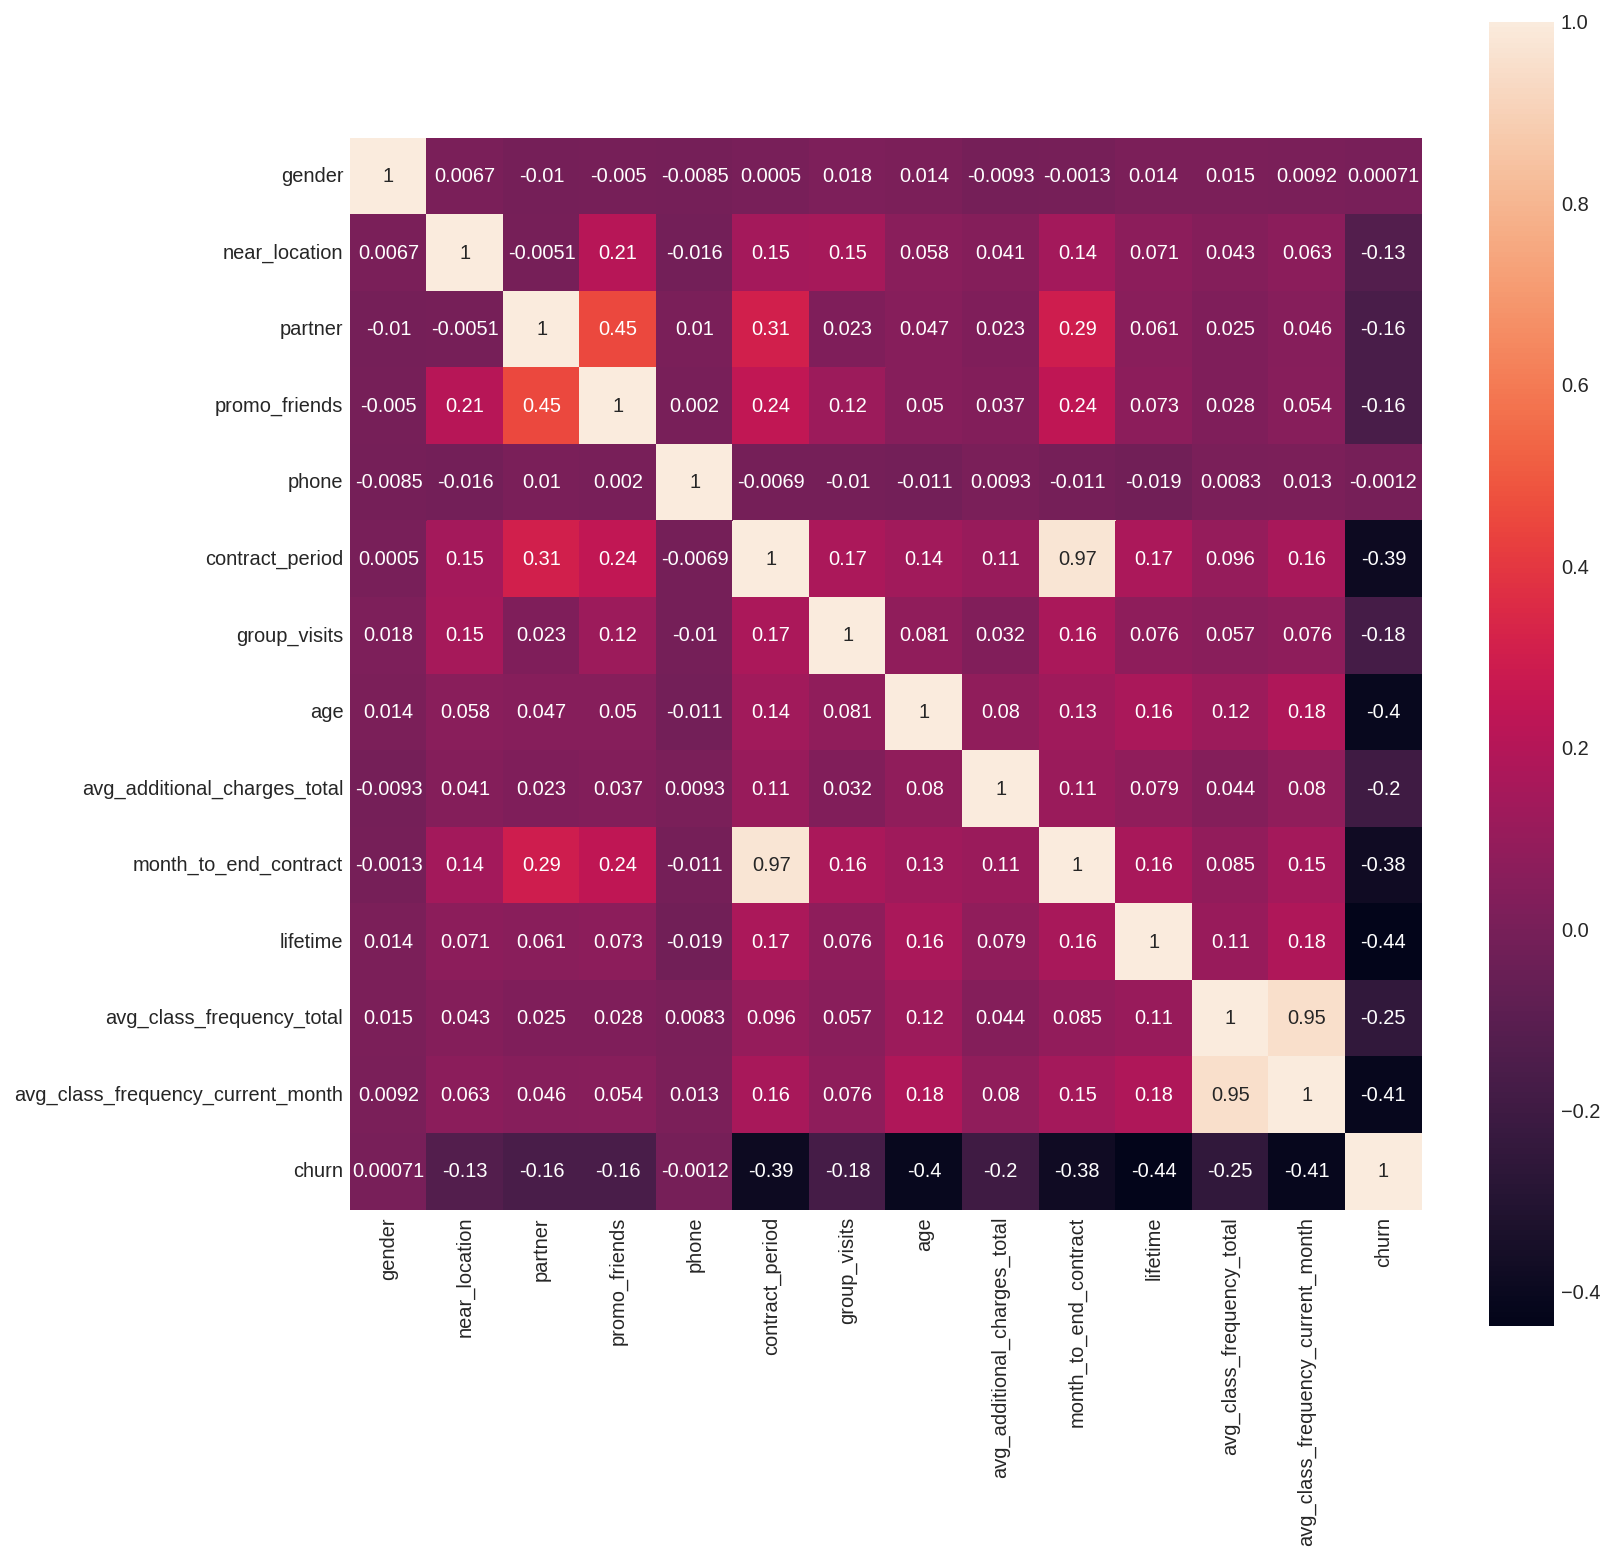

In [13]:
cm = df.corr()
fig = plt.subplots(figsize=(12,12))
sns.heatmap(cm, annot=True, square=True)
plt.show()

Сильно коррелируют между собой следующие признаки:

* Длительности абонента 'contract_period' и срок до окончания контракта 'month_to_end_contract'.
* Среднее количество посещений за месяц 'avg_class_frequency_current_month' и за весь период 'avg_class_frequency_total'.

Так как модель при высокой корреляции может быть неустойчива и склонна к переобучению, то следует удалить по одному из признаков в каждой паре:

In [14]:
df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1, inplace=True)

Проверим результат:

In [15]:
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total',
       'churn'],
      dtype='object')

<div style="border: solid green 2px; padding: 20px">

**Выводы**

* Построили сводную таблицу и графики с данными по распределению признаков для оставшихся и ушедших клиентов. Сделали вывод, что попавшие в отток большинство клиентов возраста в среднем 27 лет, которые редко посещали клуб и заключали контракт сроком на один месяц.
* Согласно полученной матрице корреляции на отток в большей степени влияют время с момента первого обращения в фитнес-центр (44%), средняя частота посещения в месяц (41%), контрактный период (39%) и срок до окончания текущего действующего абонемента (38%).
* Удалили столбцы 'month_to_end_contract' и 'avg_class_frequency_current_month' с признакими сильной корреляции.</div>

<a name="4"><h2>4 Модель прогнозирования оттока клиентов</h2></a>

Разделим данные на признаки (матрица X) и целевую переменную (y):

In [16]:
X = df.drop('churn', axis=1)
y = df['churn']

Разделим данные на обучающую и валидационную выборку:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные:

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Создадим модели для метода логистической регрессии и метода случайного леса, задав соответствующие алгоритмы LogisticRegression и RandomForestClassifier:

In [19]:
model_lr = LogisticRegression(solver='liblinear', random_state=0)
model_rf = RandomForestClassifier(random_state=0)

Напишем функцию, которая будет обучать модель, делать прогнозы и выводить метрики accuracy, precision и recall:

In [20]:
def metrics(model, name):
    model.fit(X_train_st, y_train)
    predictions = model.predict(X_test_st)
    print(name)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Обратимся к функции и выведем метрики для метода логистической регрессии:

In [21]:
metrics(model_lr, 'Логистическая регрессия:')

Логистическая регрессия:
Accuracy: 0.90
Precision: 0.79
Recall: 0.81


Выведем метрики для метода случайный лес:

In [22]:
metrics(model_rf, 'Случайный лес:')

Случайный лес:
Accuracy: 0.89
Precision: 0.79
Recall: 0.76


<div style="border: solid green 2px; padding: 20px">

**Вывод**

Модель логистической регрессии показала выше долю правильных ответов на 1% и полноту на 5%, точность в обоих моделях одинаковая (79%).</div>

<a name="5"><h2>5 Кластеризация клиентов</h2></a>

Стандартизируем данные методом StandartScaler:

In [23]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Построим дендограмму:

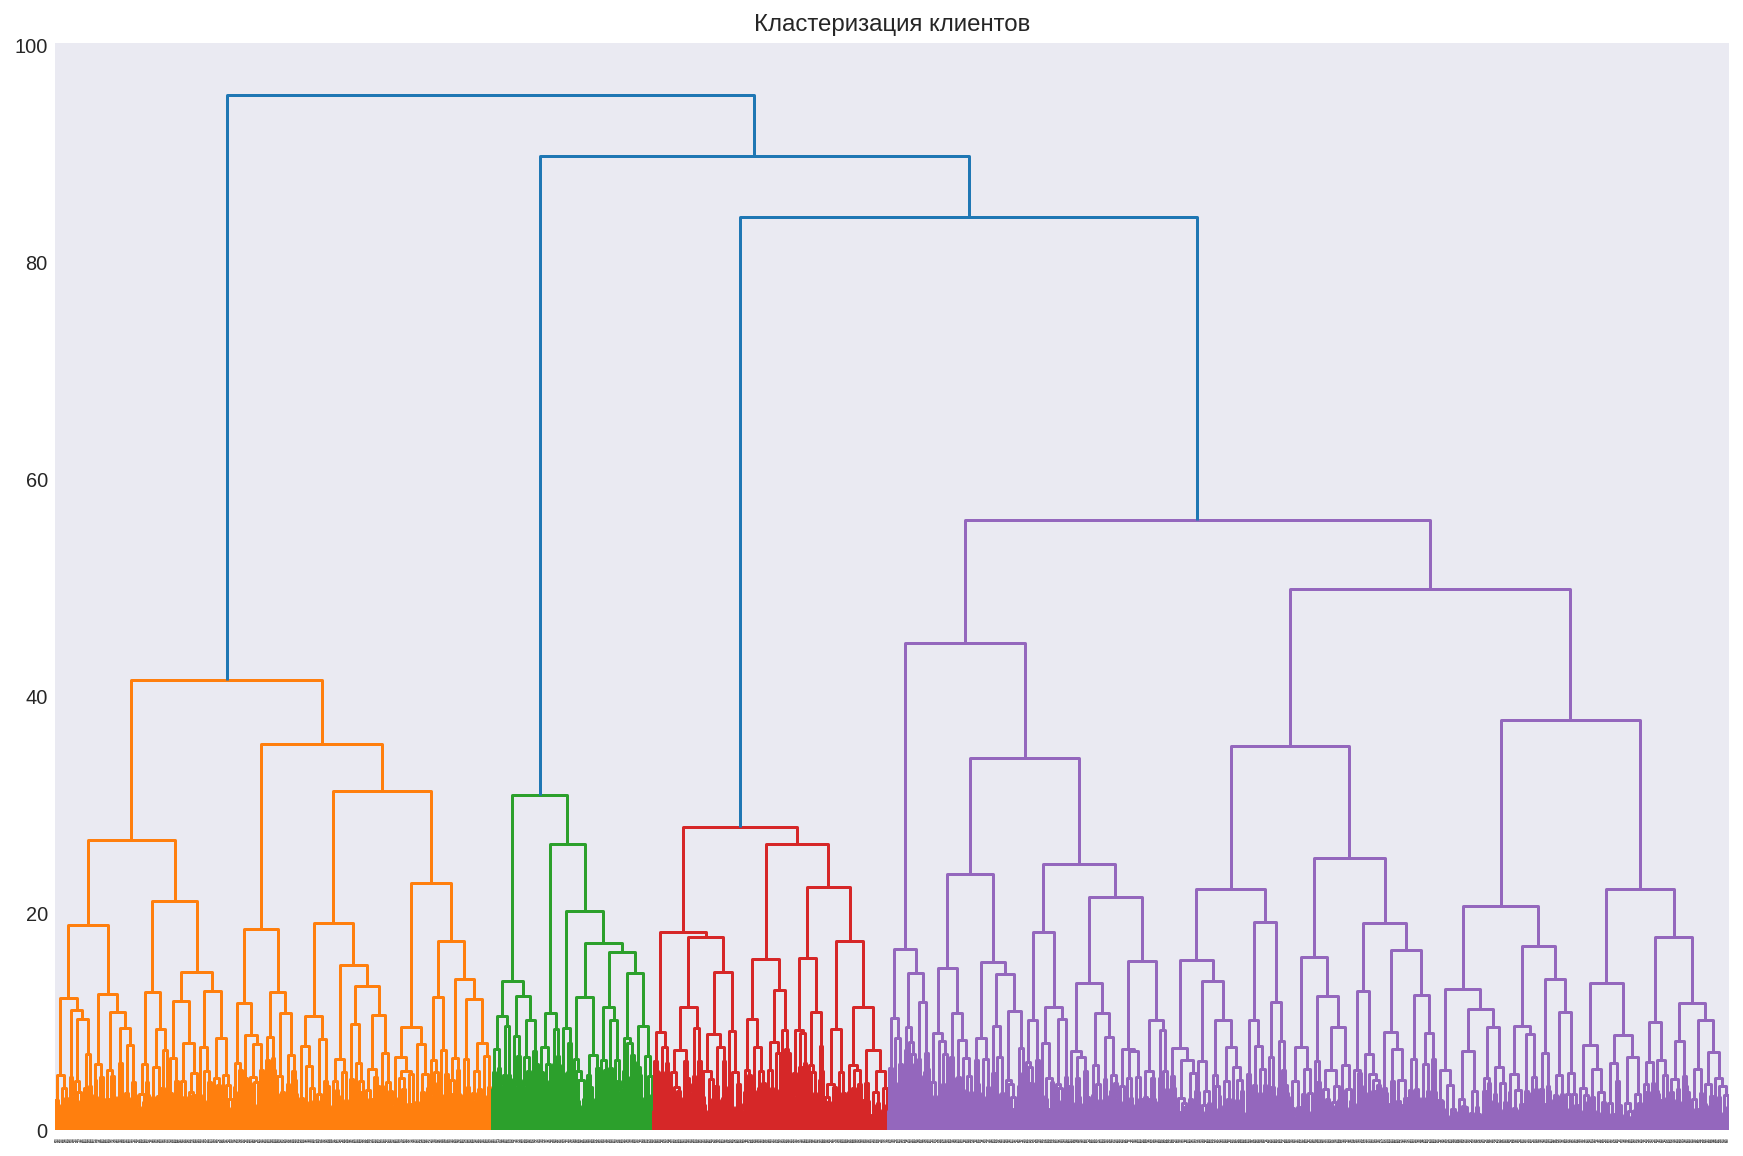

In [24]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', leaf_font_size=1)
plt.title('Кластеризация клиентов')
plt.show()

На графике выделяется 4 кластера.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов, число кластеров укажем 5 в соответствии с заданием:

In [25]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

Сохраняем метки кластера в таблицу df:

In [26]:
df['cluster'] = labels

Выделим две таблицы для клиентов, которые ушли в отток и остались:

In [27]:
df_remain = df.query('churn == 0')
df_outflow = df.query('churn == 1')

Выводим статистику по средним значениям признаков по кластерам для оставшихся клиентов:

In [28]:
df_remain.drop('churn', axis=1).groupby('cluster').agg('mean').round(2).T

cluster,0,1,2,3,4
gender,0.50,0.49,0.50,0.54,0.52
near_location,0.00,1.00,1.00,1.00,0.89
partner,0.55,0.95,0.25,0.27,0.50
promo_friends,0.10,0.88,0.05,0.08,0.36
phone,1.00,1.00,1.00,1.00,0.00
contract_period,4.08,8.35,3.57,5.25,5.86
group_visits,0.28,0.48,0.00,1.00,0.46
age,29.88,29.93,29.88,30.15,30.08
avg_additional_charges_total,150.34,161.51,160.16,157.15,157.05
lifetime,4.43,4.86,4.76,4.48,5.03


Выводим статистику по средним значениям признаков по кластерам для ушедших клиентов:

In [29]:
df_outflow.drop('churn', axis=1).groupby('cluster').agg('mean').round(2).T

cluster,0,1,2,3,4
gender,0.50,0.46,0.51,0.54,0.52
near_location,0.00,0.99,1.00,1.00,0.80
partner,0.39,1.00,0.21,0.18,0.39
promo_friends,0.04,0.98,0.07,0.09,0.16
phone,1.00,1.00,1.00,1.00,0.00
contract_period,1.46,2.69,1.61,1.65,1.80
group_visits,0.16,0.31,0.00,1.00,0.33
age,26.98,26.76,26.98,27.10,27.15
avg_additional_charges_total,118.28,114.80,116.20,112.06,108.92
lifetime,1.00,0.92,1.05,0.90,0.95


Построим графики распределения признаков бинарного и дискретного типа по кластерам:

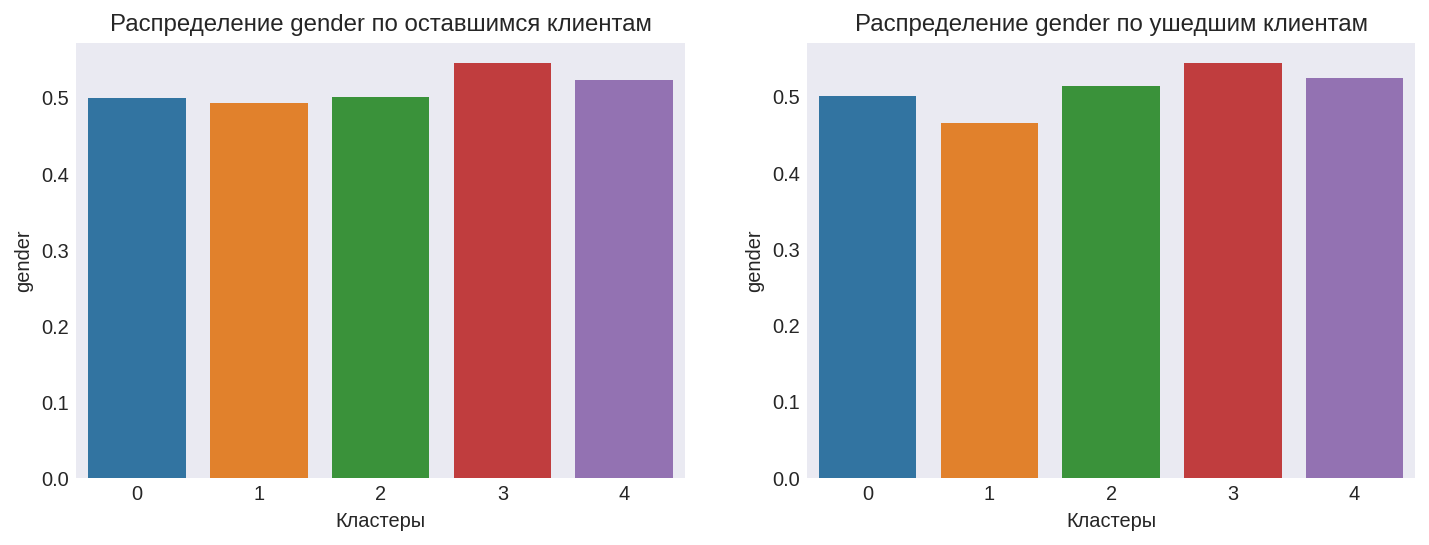

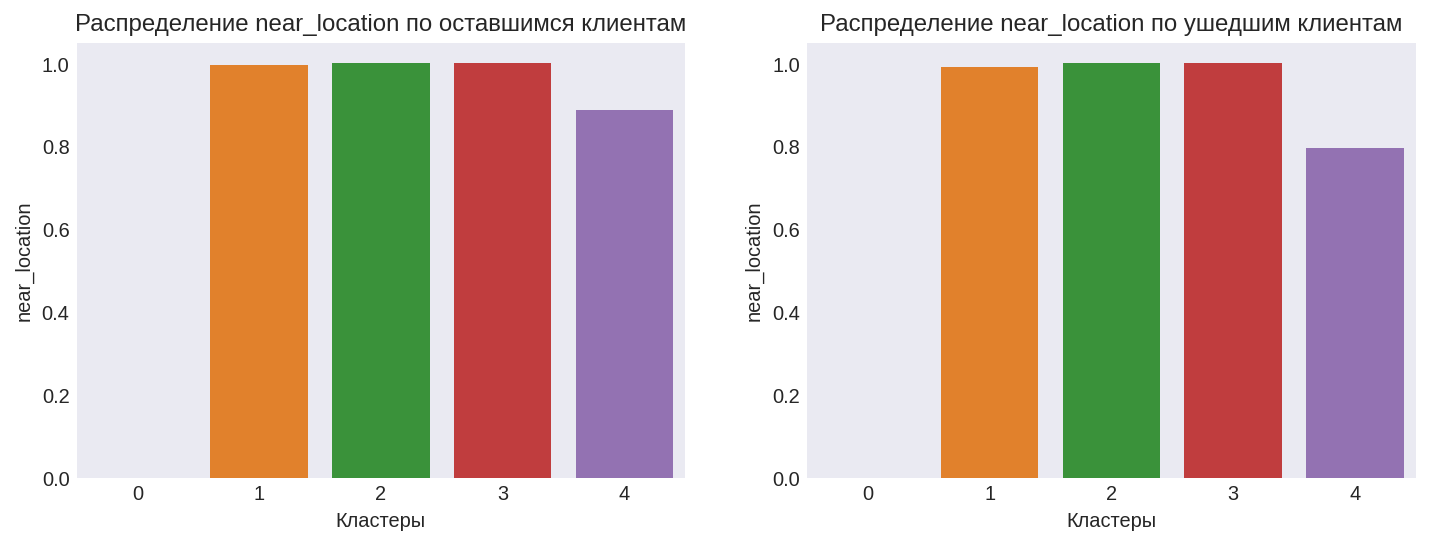

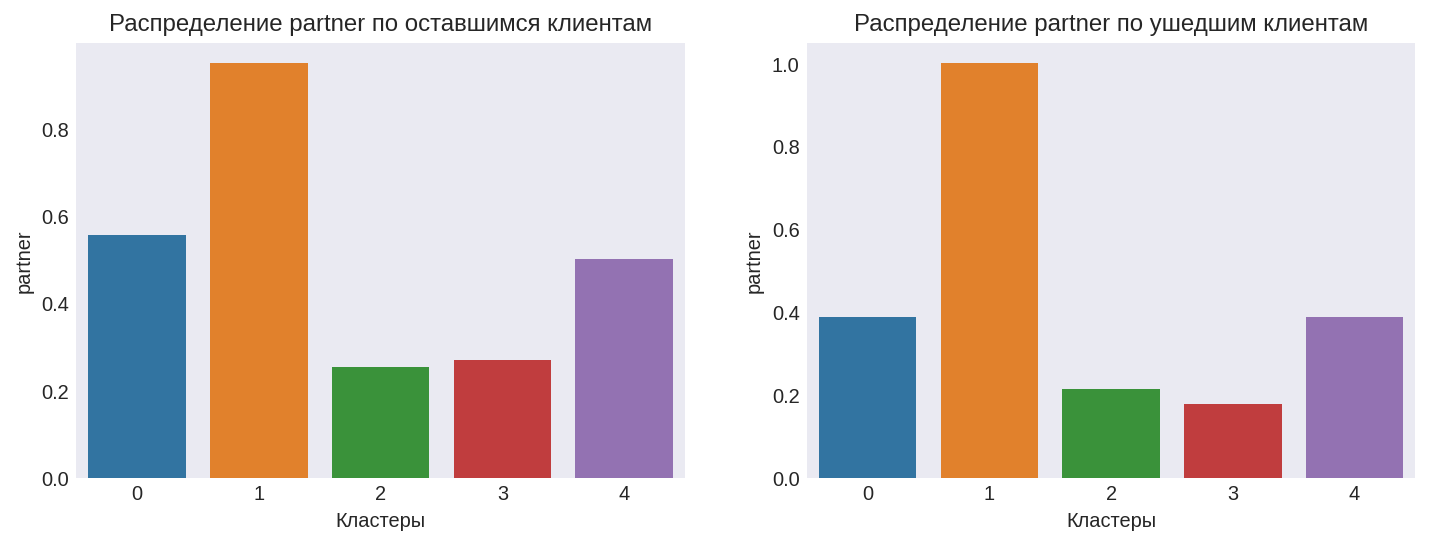

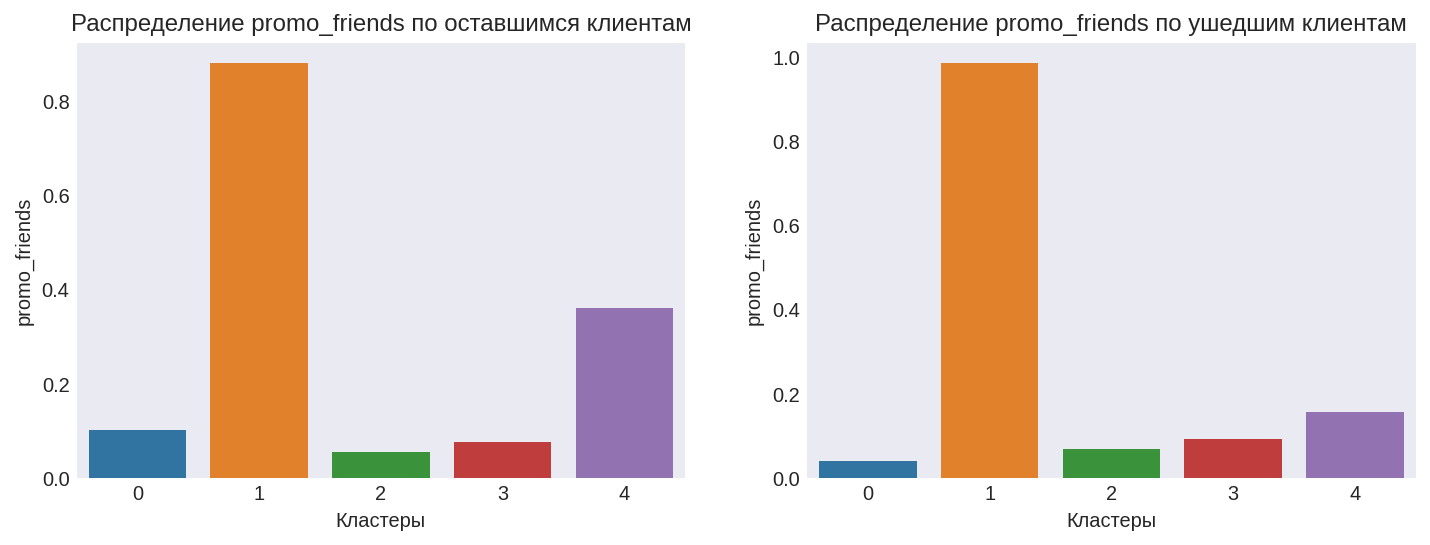

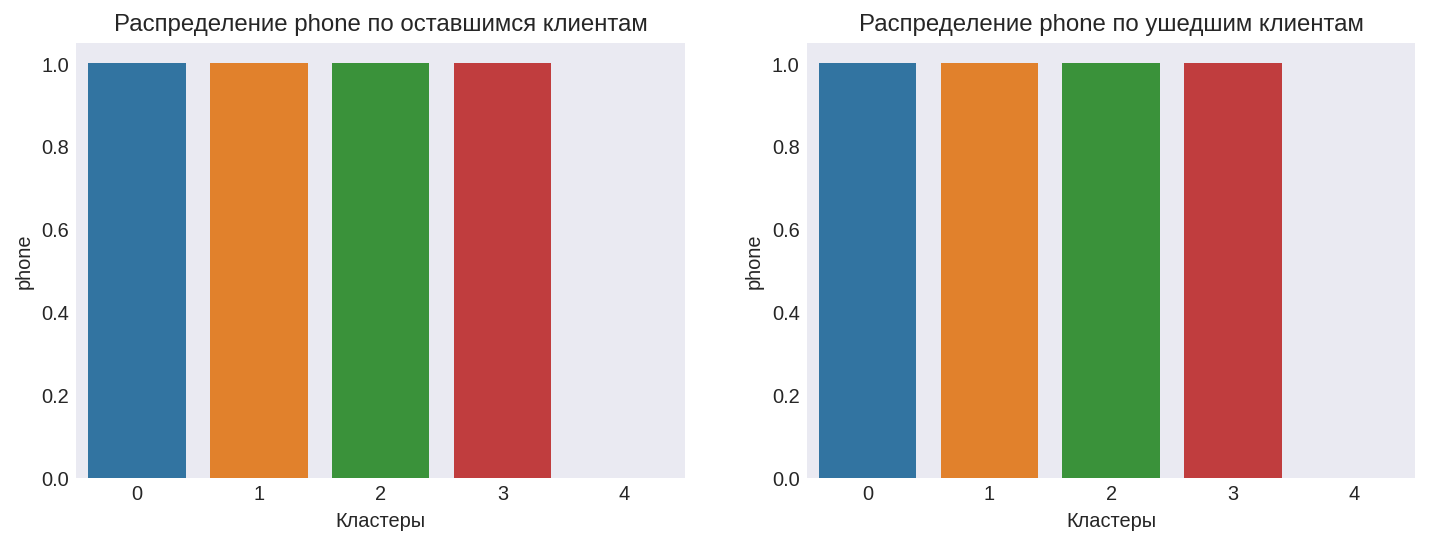

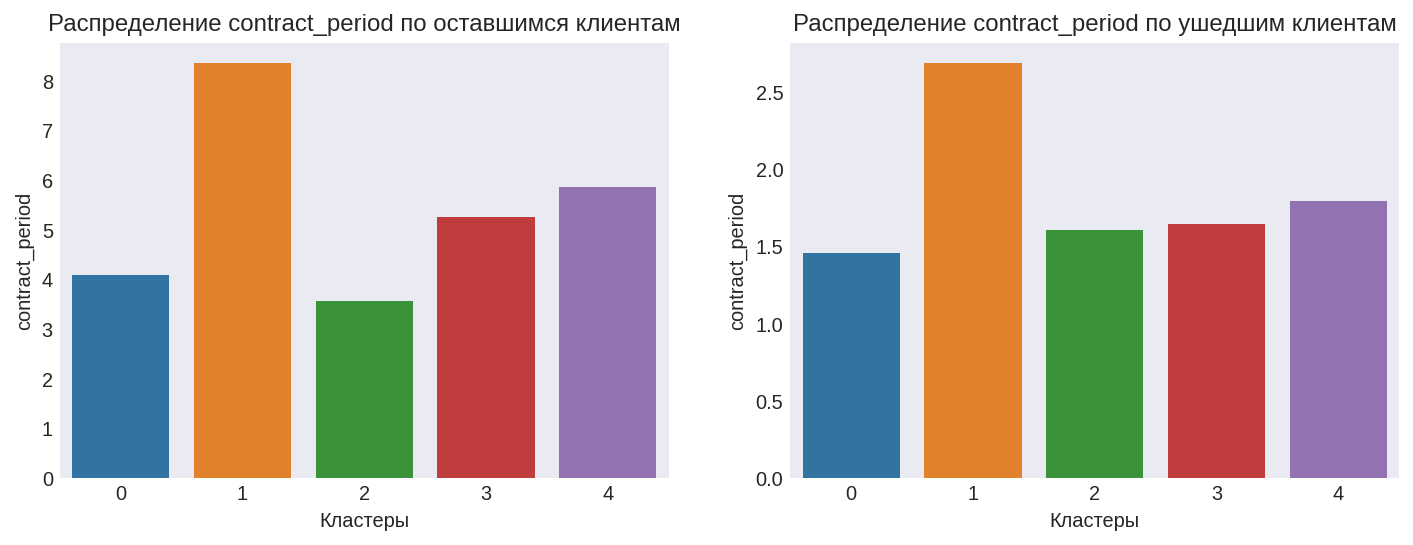

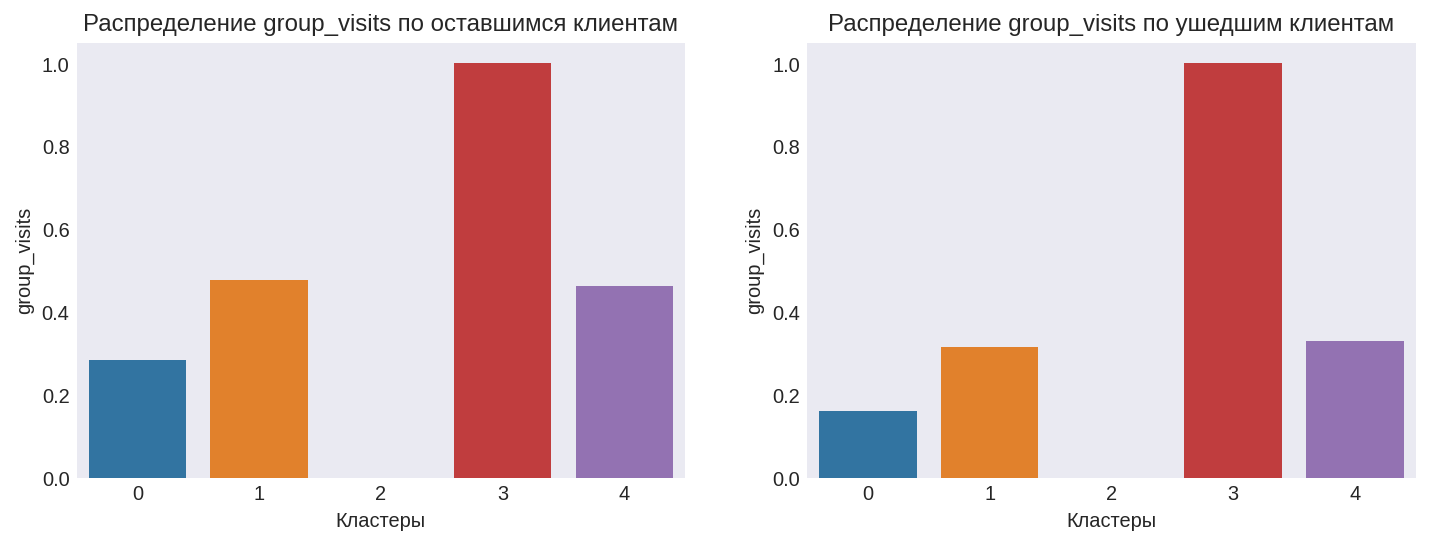

In [30]:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']
for column in columns:
    figure, ax = plt.subplots(1,2,figsize=(12,4))
    sns.barplot(x=df_remain['cluster'], y=df_remain[column], ci = None, ax=ax[0]);
    sns.barplot(x=df_outflow['cluster'], y=df_outflow[column], ci = None, ax=ax[1])
    ax[0].set_title('Распределение '+ str(column) + ' по оставшимся клиентам')
    ax[1].set_title('Распределение '+ str(column) + ' по ушедшим клиентам')  
    ax[0].set_xlabel('Кластеры')
    ax[1].set_xlabel('Кластеры')
    plt.show()

Выведем графики распределения признаков непрерывного типа по кластерам для ушедших и оставшихся клиентов:

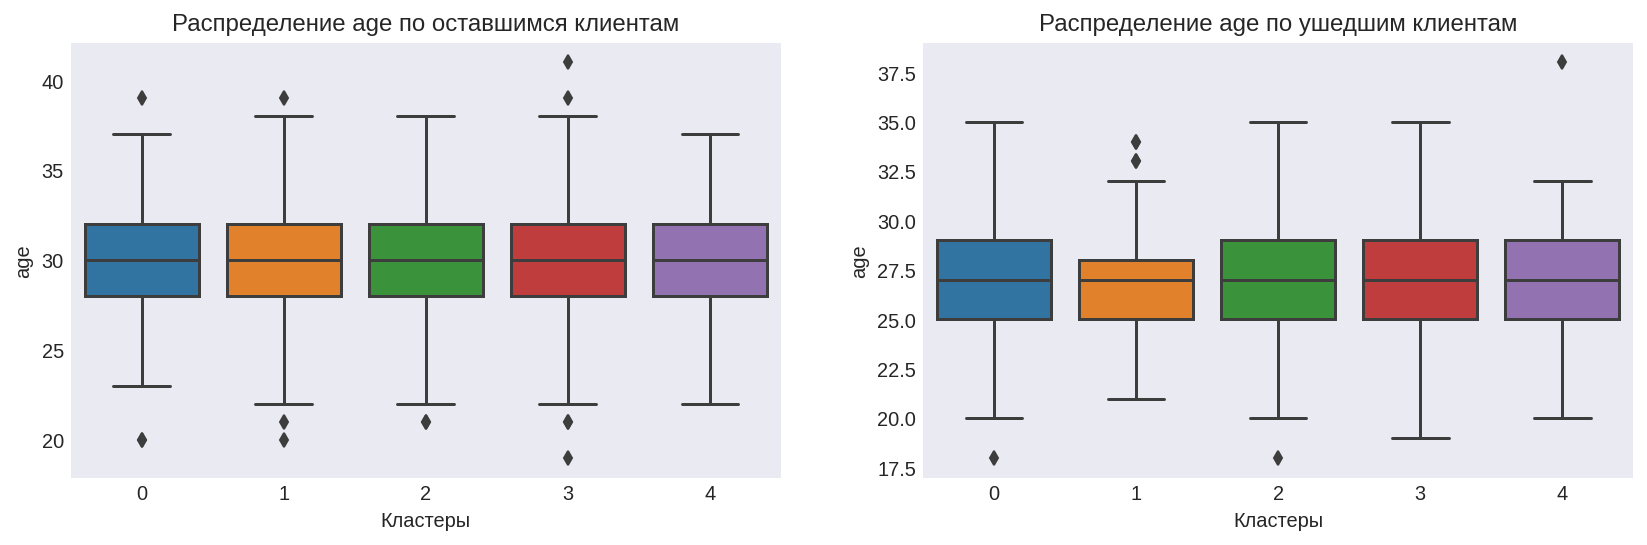

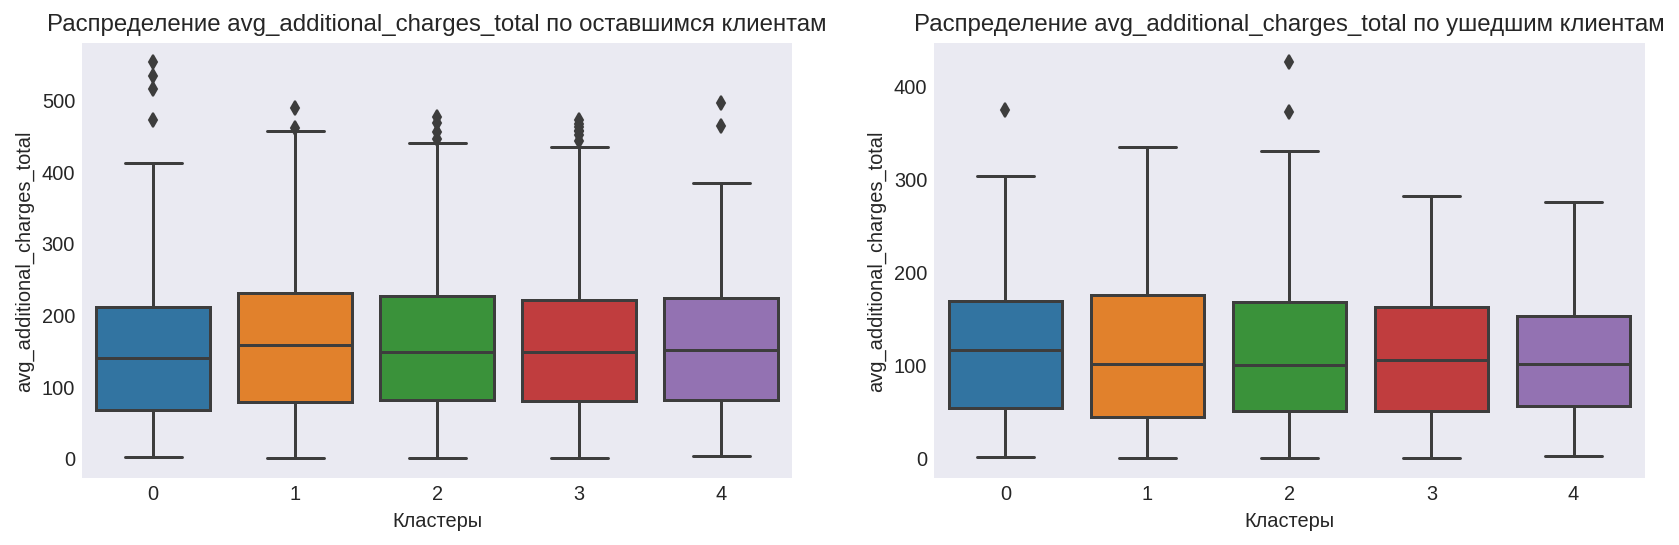

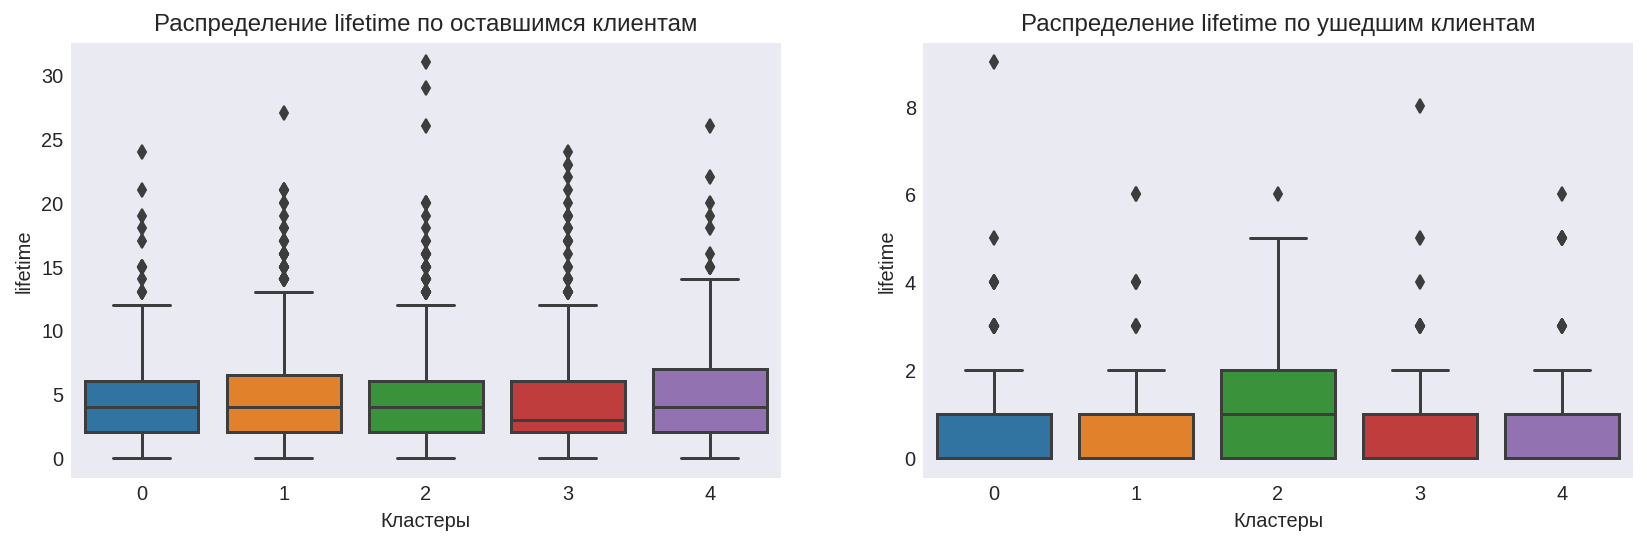

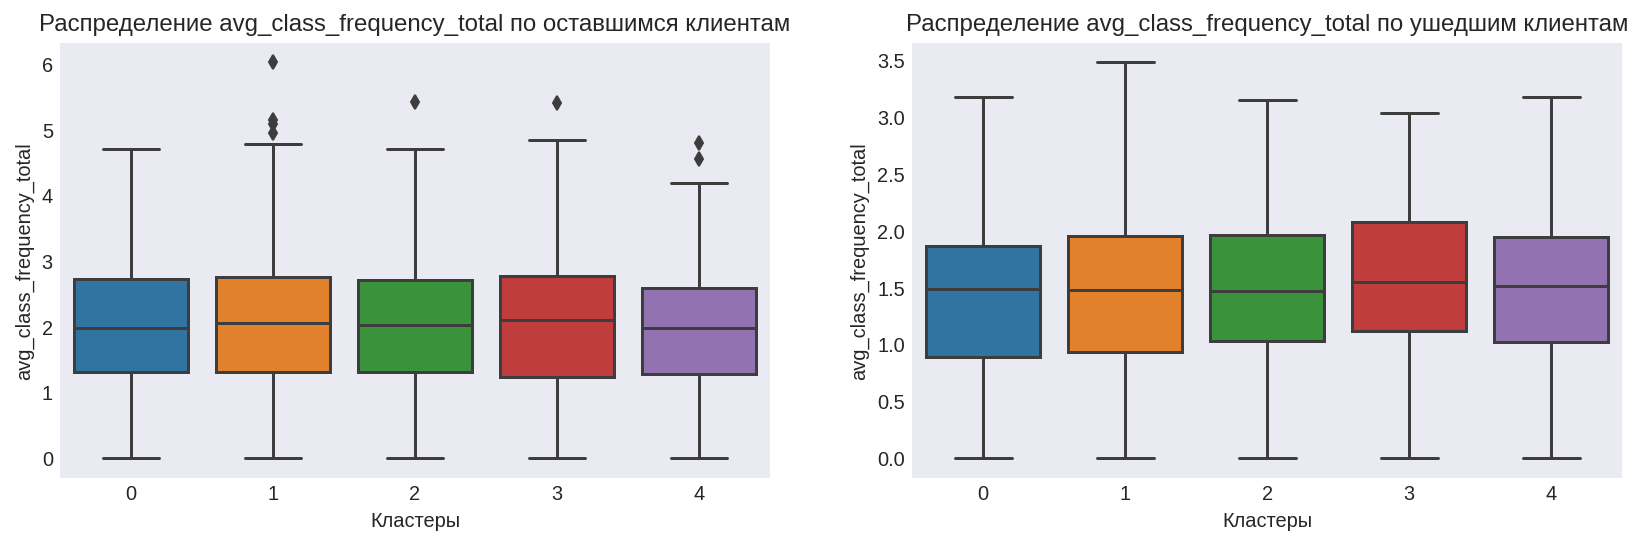

In [31]:
columns = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']
for column in columns:
    figure, ax = plt.subplots(1,2,figsize=(14,4))
    sns.boxplot(x=df_remain['cluster'], y=df_remain[column], data=df_remain, ax=ax[0]);
    sns.boxplot(x=df_outflow['cluster'], y=df_outflow[column], data=df_outflow, ax=ax[1])
    ax[0].set_title('Распределение '+ str(column) + ' по оставшимся клиентам')
    ax[1].set_title('Распределение '+ str(column) + ' по ушедшим клиентам')  
    ax[0].set_xlabel('Кластеры')
    ax[1].set_xlabel('Кластеры')
    plt.show()

Выделим основные характеристики по ушедшим клиентам:

0 кластер:
* отсутствие клиентов, которые живут или работают рядом;
* мало клиентов посещают групповые занятия (16%);
* в среднем длительность контракта 1,5 месяца;
* только 4% клиентов пришли по акции 'приведи друга';
* средняя частота посещений в неделю 1,4 раза.

1 кластер:
* 99% клиентов живут или работают рядом с клубом;
* все клиенты являются сотрудниками компаний-партнёров;
* самое большое число клиентов, пришедших по приглашению друга (98%);
* в среднем заключается наиболее длительный контактный период на 2,7 месяцев;
* 30% клиентов посещают групповые занятия;
* время с момента первого обращения меньше месяца.

2 кластер:
* у 100% клиентов расположение рядом с домом или работой;
* только 21% являются сотрудниками компаний-партнеров;
* по акции 'приведи друга' пришло 7% клиентов;
* нет клиентов, которые посещают групповые занятия;
* по признаку 'lifetime' межквартильный размах шиире, чем в других кластерах и чаще составляет 2 месяца, но в среднем время продолжительности также составляет 1 месяц.

3 кластер:
* самое небольшое число клиентов, которые являются сотрудниками партнёров (18%);
* по приглашению друга пришли 9%;
* в среднем длительность контракта 1,65 месяца;
* все клиенты посещают групповые занятия;
* время продолжительности посещений меньше месяца;
* чуть выше средняя частота посещений в неделю, чем в других кластерах, в среднем составляет 1,56%

4 кластер:
* у 80% клиентов клуб расположен поблизости от дома или работы;
* по партнерской программе посещают 39%;
* по приглашению друга пришли 16%;
* контрактный период в среднем 1,8 месяца;
* 33% посещают групповые занятия.

Нет существенной разницы по кластерам для признаков пол, номер телефона, возраст и средняя сумма на дополнительные расходы.

Посчитаем долю оттока для каждого кластера:

In [32]:
round(df.groupby('cluster')['churn'].agg(['sum'])/df['churn'].sum(),2)

,sum
cluster,
0,0.21
1,0.12
2,0.41
3,0.16
4,0.10


Самая большая доля ушедших (41%) во 2 кластере, меньшая доля оттока в кластерах 4 и 1 (10% и 12% соответственно).

<a name="6"><h2>6 Общие выводы</h2></a>

В результате работы провели исследовательский анализа данных, построили и изучили матрицу корреляции, обучили модели для прогнозирования оттока клиентов и провели класстеризацию. 

По итогам анализа данных можно выделить основные признаки клиентов, которые могут уйти в отток:
* Приобретение абонемента на один месяц;
* Редкое посещение клуба до двух раз в неделю, чаще 1 раз;
* Отсутствие групповых занятий (из ушедших только 27% посещали групповые занятия, из оставшихся таких клиентов на 20% больше);
* Не является сотрудником компании-партнёра (53% клиентов посещают клуб по партнерской программе, из ушедших таких клиентов было 36%);
* Отсутствие поблизости дома или места работы (из ушедших у 77% клуб находился рядом, из оставшися у 87%);
* Возраст младше 27 лет.


Согласно матрице корреляции на отток оказывают наибольшее влияние следующие признаки:
* Время в месяцах с момента первого обращения в фитнес-центр 'lifetime' - 44%;
* Средняя частота посещения 'avg_class_frequency_current_month' в месяц - 41%;
* Длительность контрактного периода 'contract_period' - 39%;
* Cрок до окончания текущего действующего абонемента 'month_to_end_contract' - 38%.

Клиенты, которые с большей вероятностью продолжат посещение клуба, приобретают более длительные абонементы, чаще посещают зал в неделю, живут или работают поблизости, чаще участвуют в партнерских и групповых программах, приходят по приглашению друга, а также активнее пользуются дополнительными услугами.

Обучив модели логистической регрессией и случайным лесом, установили, что модель логистической регрессии показывает выше долю правильных ответов - 90% и полноту - 81%, в модели случайного леса эти метрики равны 89% и 76% соответственно. Точность в обоих случаях равна 79%.

В результате кластеризации выделили 5 кластеров, из которых более надежными оказались 4 и 1, доля оттока в этих группах составила 10 и 12 процентов, наибольший отток во втором кластере составил 41%. Если рассматривать кластеры по основным характеристикам, то наиболее надежным выглядит 1 кластер.

Рекомендации для привлечения и удержания клиентов:
* Так как ушедшие клиенты обычно посещают клуб 1 месяц и в целом реже посещают фитнес-центр, то предлагается рассмотреть возможность введения акции на 2 месяц или после определенного числа посещений;
* Расширить список компаний-партнёров;
* Привлекать новых клиентов к групповым занятиям;
* Проводить рекламу в районе местоположения фитнес-центра, чтобы привлечь тех, кто живёт или работает рядом;
* Активное продвижение акции 'пригласи друга'.
* Рассмотреть причины оттока клиентов младше 27 лет, а также отсутствия клиентов более старшей категории после 41 года и оценить условия конкурентов, которые привлекают лиц данных возрастных категорий, возможно следует улучшить сервис и качество предоставляемых услуг.